目标函数定义为:
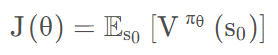

对该函数求导:
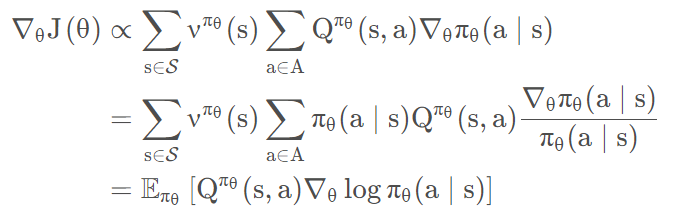

使用蒙特卡洛采样时,可得如下导函数:
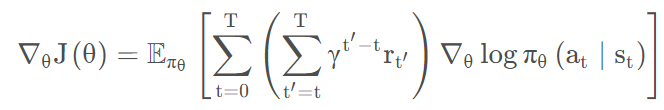

/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_

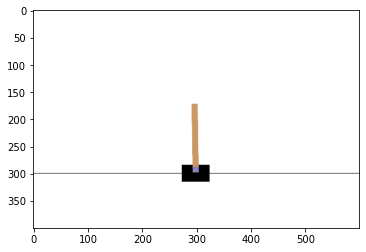

In [1]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('CartPole-v0')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [2]:
import torch

#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),
)

model(torch.randn(2, 4))

tensor([[0.2774, 0.7226],
        [0.5612, 0.4388]], grad_fn=<SoftmaxBackward0>)

In [3]:
import random


#得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)

    #[1, 4] -> [1, 2]
    prob = model(state)

    #根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])

0

In [4]:
#得到一局游戏的数据
def get_data():
    states = []
    rewards = []
    actions = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step(action)

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)

        #更新游戏状态,开始下一个动作
        state = next_state

    return states, rewards, actions


get_data()

([array([-0.01772649, -0.00929429, -0.01335113,  0.04096572], dtype=float32),
  array([-0.01791238,  0.18601654, -0.01253182, -0.25589955], dtype=float32),
  array([-0.01419205, -0.00892427, -0.01764981,  0.03280446], dtype=float32),
  array([-0.01437053,  0.18644628, -0.01699372, -0.2653945 ], dtype=float32),
  array([-0.01064161,  0.3818066 , -0.02230161, -0.5633886 ], dtype=float32),
  array([-0.00300547,  0.18700457, -0.03356938, -0.27781433], dtype=float32),
  array([ 0.00073462,  0.38258895, -0.03912567, -0.58089316], dtype=float32),
  array([ 0.0083864 ,  0.57823664, -0.05074353, -0.88564014], dtype=float32),
  array([ 0.01995113,  0.38383898, -0.06845633, -0.60933113], dtype=float32),
  array([ 0.02762791,  0.57984775, -0.08064295, -0.9227661 ], dtype=float32),
  array([ 0.03922486,  0.3859025 , -0.09909828, -0.65647703], dtype=float32),
  array([ 0.04694292,  0.5822542 , -0.11222782, -0.9786467 ], dtype=float32),
  array([ 0.058588  ,  0.77868724, -0.13180076, -1.3043684 ], dt

In [5]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

36.0

In [6]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    #玩N局游戏,每局游戏训练一次
    for epoch in range(1000):
        #玩一局游戏,得到数据
        states, rewards, actions = get_data()

        optimizer.zero_grad()

        #反馈的和,初始化为0
        reward_sum = 0

        #从最后一步算起
        for i in reversed(range(len(states))):

            #反馈的和,从最后一步的反馈开始计算
            #每往前一步,>>和<<都衰减0.02,然后再加上当前步的反馈
            reward_sum *= 0.98
            reward_sum += rewards[i]

            #重新计算对应动作的概率
            state = torch.FloatTensor(states[i]).reshape(1, 4)
            #[1, 4] -> [1, 2]
            prob = model(state)
            #[1, 2] -> scala
            prob = prob[0, actions[i]]

            #根据求导公式,符号取反是因为这里是求loss,所以优化方向相反
            loss = -prob.log() * reward_sum

            #累积梯度
            loss.backward(retain_graph=True)

        optimizer.step()

        if epoch % 100 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, test_result)


train()

0 16.2
100 35.5
200 73.0
300 176.3
400 173.3
500 200.0
600 188.2
700 171.8
800 190.4
900 158.5


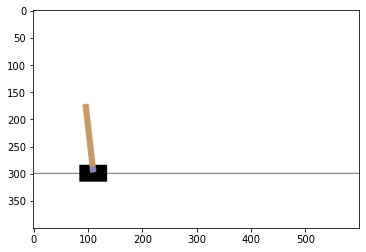

200.0

In [7]:
test(play=True)